## Dependencias

In [1]:
!pip install pandas scipy pillow
!rm -rf ~/.nv

     |████████████████████████████████| 9.5 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 85.7 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 68.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import models,layers,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta as rd
import os
import shutil

In [3]:
ini =datetime.now()

In [4]:
tf.__version__

'2.6.0'

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

## Preparación de estructura de directorios y archivos

In [8]:
ruta = '/tf/bd/dogs-vs-cats/train/'
dest = '/tf/bd/cats_dogs_mini/'
categorias =['cat','dog']
segmentos =['train','validate','test']

In [12]:
df = pd.DataFrame({'archivo':os.listdir(ruta)})
df['tipo'] = df['archivo'].map(lambda x:'cat' if 'cat' in x else 'dog')
cats,dogs = [d.sample(n=2000).reset_index(drop=True) for _,d in df.groupby('tipo')]

In [15]:
cats['muestra'] = (cats.index)//500
dogs['muestra'] = (dogs.index)//500
cats['muestra'] = cats['muestra'].map({0:'train',1:'train',2:'validate',3:'test'})
dogs['muestra'] = dogs['muestra'].map({0:'train',1:'train',2:'validate',3:'test'})

In [19]:
os.system('rm -rf '+dest+"*")
for s in segmentos:
    os.mkdir(os.path.join(dest,s))
    for c in categorias:
        os.mkdir(os.path.join(dest,s,c))

In [20]:
cats = [[(os.path.join(ruta,a),os.path.join(dest,tipo,'cat',a)) for a in d['archivo'].tolist()] for tipo,d in cats.groupby('muestra')]
dogs = [[(os.path.join(ruta,a),os.path.join(dest,tipo,'dog',a)) for a in d['archivo'].tolist()] for tipo,d in dogs.groupby('muestra')]

In [24]:
for l in cats:
    for t in l:
        shutil.copyfile(*t)

In [25]:
for l in dogs:
    for t in l:
        shutil.copyfile(*t)

In [9]:
for root, subdirs, files in os.walk(dest):
    for d in [os.path.join(root,sd) for sd in subdirs]:
        print(d,len(os.listdir(d)))

/tf/bd/cats_dogs_mini/train 2
/tf/bd/cats_dogs_mini/validate 2
/tf/bd/cats_dogs_mini/test 2
/tf/bd/cats_dogs_mini/train/dog 1000
/tf/bd/cats_dogs_mini/train/cat 1000
/tf/bd/cats_dogs_mini/validate/dog 500
/tf/bd/cats_dogs_mini/validate/cat 500
/tf/bd/cats_dogs_mini/test/dog 500
/tf/bd/cats_dogs_mini/test/cat 500


## Arquitectura de la CNN

In [10]:
modelo = models.Sequential()
modelo.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(64,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Flatten())
modelo.add(layers.Dense(512,activation='relu'))
modelo.add(layers.Dense(1,activation='sigmoid'))

In [11]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [12]:
modelo.compile(loss='binary_crossentropy',
               optimizer = optimizers.RMSprop(learning_rate=1e-4),
               metrics=['acc'])

## Preparación de datos

In [13]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [14]:
train = train.flow_from_directory(os.path.join(dest,'train'),
                                  target_size=(150,150),
                                  batch_size=20,
                                  class_mode='binary')

Found 2000 images belonging to 2 classes.


In [15]:
validation = test.flow_from_directory(os.path.join(dest,'validate'),
                                  target_size=(150,150),
                                  batch_size=20,
                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


## Entrenar el modelo (sobreajusta)

In [16]:
history = modelo.fit(train,
                     steps_per_epoch=100,
                     epochs=30,
                     validation_data=validation,
                     validation_steps=50)

Epoch 1/30
100/100 [==============================] - 10s 67ms/step - loss: 0.6863 - acc: 0.5435 - val_loss: 0.6966 - val_acc: 0.5030
Epoch 2/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6530 - acc: 0.6265 - val_loss: 0.6254 - val_acc: 0.6610
Epoch 3/30
100/100 [==============================] - 7s 66ms/step - loss: 0.6086 - acc: 0.6530 - val_loss: 0.5854 - val_acc: 0.7090
Epoch 4/30
100/100 [==============================] - 7s 67ms/step - loss: 0.5699 - acc: 0.6980 - val_loss: 0.6089 - val_acc: 0.6500
Epoch 5/30
100/100 [==============================] - 7s 66ms/step - loss: 0.5417 - acc: 0.7100 - val_loss: 0.6397 - val_acc: 0.6180
Epoch 6/30
100/100 [==============================] - 7s 70ms/step - loss: 0.5228 - acc: 0.7355 - val_loss: 0.5616 - val_acc: 0.7090
Epoch 7/30
100/100 [==============================] - 7s 71ms/step - loss: 0.5002 - acc: 0.7475 - val_loss: 0.5518 - val_acc: 0.7120
Epoch 8/30
100/100 [==============================] - 7s 71ms/step -

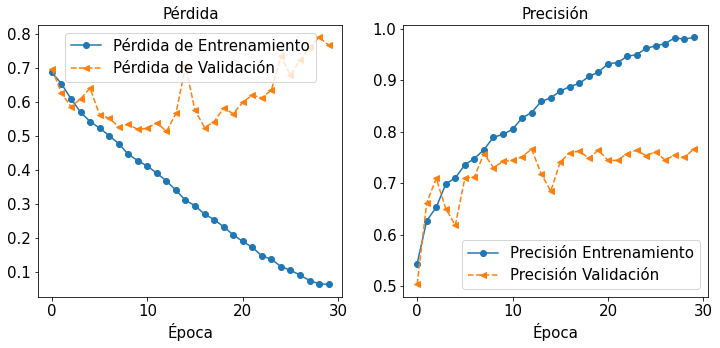

In [17]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['acc'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_acc'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

## Entrenamiento con data augmentation

In [18]:
train = ImageDataGenerator(rotation_range=40, #Rota las imágenes aleatoriamente
                           width_shift_range=0.2, # Traslada horizontalmente
                           height_shift_range=0.2, #Traslada verticalmente
                           shear_range=0.2, #transformaciones de corte (cizalla)
                           zoom_range=0.2, #acercamientos aleatorios
                           horizontal_flip=True, #Voltea horizontalmente
                           fill_mode='nearest' #rellena pixeles vacíos
                          )

In [19]:
gatos = [os.path.join(dest,'train','cat',x) for x in os.listdir(os.path.join(dest,'train','cat'))]
perros = [os.path.join(dest,'train','dog',x) for x in os.listdir(os.path.join(dest,'train','dog'))]

In [20]:
perros[:2]

['/tf/bd/cats_dogs_mini/train/dog/dog.11625.jpg',
 '/tf/bd/cats_dogs_mini/train/dog/dog.4157.jpg']

In [21]:
img = image.load_img(perros[3],target_size=(150,150))

In [22]:
x = image.img_to_array(img)

In [23]:
x = x.reshape((1,)+x.shape)

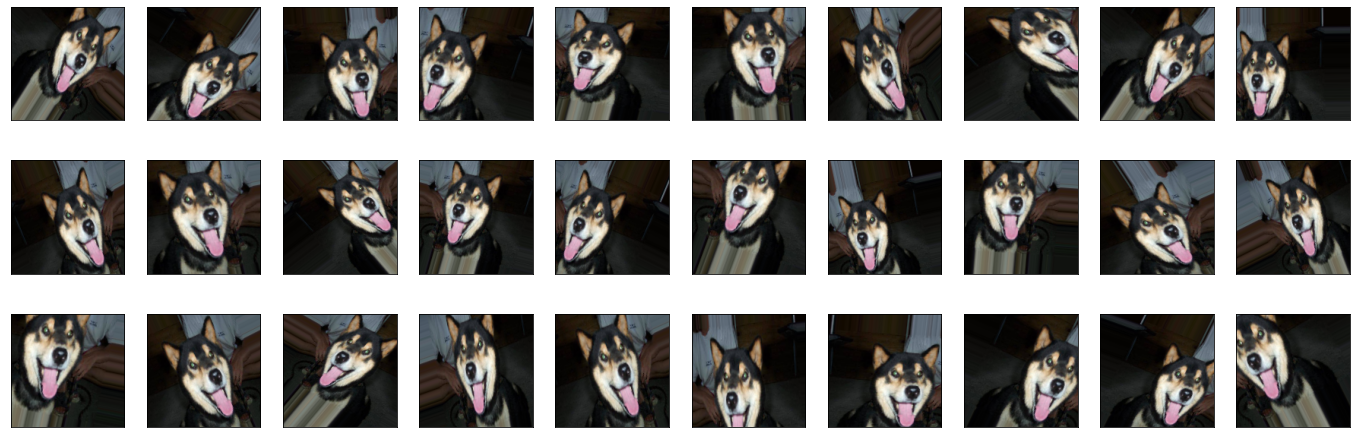

In [24]:
fig = plt.figure(figsize=(24,8))
for i,batch in enumerate(train.flow(x,batch_size=1)):
    ax = fig.add_subplot(3,10,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image.array_to_img(batch[0]))
    if (i+1)% 30 ==0:
        break
plt.show()

## Agregar una capa Dropout para evitar el sobreajuste

In [25]:
modelo = models.Sequential()
modelo.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(64,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Flatten())
modelo.add(layers.Dropout(0.5))
modelo.add(layers.Dense(512,activation='relu'))
modelo.add(layers.Dense(1,activation='sigmoid'))

In [26]:
modelo.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=1e-4),
               metrics=['acc'])

In [27]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [28]:
train = ImageDataGenerator(rotation_range=40, 
                           rescale=1/255,
                           width_shift_range=0.2, 
                           height_shift_range=0.2, 
                           shear_range=0.2, 
                           zoom_range=0.2, 
                           horizontal_flip=True, 
                          )
test = ImageDataGenerator(rescale=1/255)

In [29]:
train = train.flow_from_directory(os.path.join(dest,'train'),
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 2000 images belonging to 2 classes.


In [30]:
test = test.flow_from_directory(os.path.join(dest,'validate'),
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


In [32]:
history = modelo.fit_generator(train,
                     steps_per_epoch=2000//32,
                     epochs=30,
                     validation_data=validation,
                     validation_steps=50)

Epoch 1/30
62/62 [==============================] - 14s 225ms/step - loss: 0.6884 - acc: 0.5391 - val_loss: 0.6761 - val_acc: 0.5970
Epoch 2/30
62/62 [==============================] - 14s 230ms/step - loss: 0.6782 - acc: 0.5742 - val_loss: 0.6651 - val_acc: 0.6040
Epoch 3/30
62/62 [==============================] - 15s 237ms/step - loss: 0.6720 - acc: 0.5852 - val_loss: 0.6682 - val_acc: 0.5750
Epoch 4/30
62/62 [==============================] - 14s 227ms/step - loss: 0.6652 - acc: 0.5879 - val_loss: 0.6349 - val_acc: 0.6450
Epoch 5/30
62/62 [==============================] - 14s 230ms/step - loss: 0.6479 - acc: 0.6067 - val_loss: 0.7349 - val_acc: 0.5250
Epoch 6/30
62/62 [==============================] - 15s 236ms/step - loss: 0.6397 - acc: 0.6367 - val_loss: 0.6081 - val_acc: 0.6750
Epoch 7/30
62/62 [==============================] - 14s 229ms/step - loss: 0.6365 - acc: 0.6280 - val_loss: 0.6105 - val_acc: 0.6640
Epoch 8/30
62/62 [==============================] - 14s 233ms/step - 

In [33]:
modelo.save('cats_vs_dogs_gpu.h5')

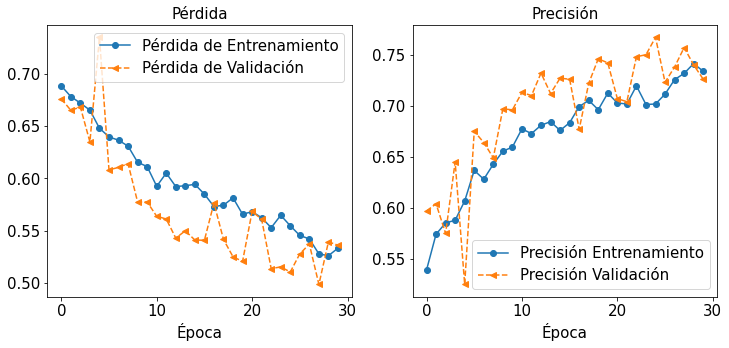

In [34]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['acc'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_acc'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

In [35]:
rd(datetime.now(),ini)

relativedelta(minutes=+19, seconds=+11, microseconds=+491929)